# Cyrillic OCR Data Generator

Generate synthetic Cyrillic text images for training OCR models.

## Installation

1. Clone the TextRecognitionDataGenerator repository:
   ```bash
   git clone https://github.com/Belval/TextRecognitionDataGenerator.git
   cd TextRecognitionDataGenerator
   pip install -e .
   ```

2. Install additional dependencies:
   ```bash
   pip install pillow opencv-python matplotlib
   ```

## Project Structure

```
OCR/
├── TextRecognitionDataGenerator/  # Cloned repository
├── corpus/                        # Russian text files
├── fonts/                         # Cyrillic font files
└── data/rec/                      # Generated images
    ├── train/                     # Training images
    └── test/                      # Test images
```

## Quick Usage Guide

### 1. Generate images using command line

```bash
cd TextRecognitionDataGenerator
python trdg/run.py -c 10 -i ../corpus/rus_corpus.txt -ft ../fonts/ocr_russia.ttf -f 48 -wd 320
```

### 2. Create custom data generation script

Create a file named `generate.py`:

```python
# Import TextRecognitionDataGenerator
from trdg.generators import GeneratorFromStrings

# Load text corpus and generate with multiple augmentations
# See our notebook for complete implementation
```

### 3. Create train/test split

```bash
# Copy a subset of training images to test directory
# Update annotation file paths accordingly
```

## Augmentation Options

| Type | Description |
|------|-------------|
| No augmentation | Clean text |
| Skew | Rotated text |
| Blur | Blurred text (3 levels) |
| Distortion | Wavy text (sine, cosine, random) |

## Tips

- Use UTF-8 encoded Russian text corpus
- Include diverse OCR-friendly Cyrillic fonts
- Balance augmentations for realistic training data
- Standard image height: 32-48px, width: ~320px
- See our Jupyter notebook for detailed implementation

## References

- [TextRecognitionDataGenerator GitHub](https://github.com/Belval/TextRecognitionDataGenerator)
- [PaddleOCR GitHub](https://github.com/PaddlePaddle/PaddleOCR)


In [4]:
# Cell 1: Generate Synthetic Cyrillic Text Data using TextRecognitionDataGenerator
# Run from TextRecognitionDataGenerator directory with provided parameters
!cd /home/ubuntu/OCR/TextRecognitionDataGenerator/trdg
!python /home/ubuntu/OCR/TextRecognitionDataGenerator/trdg/run.py \
    -c 10 \
    -i /home/ubuntu/OCR/corpus/rus_corpus.txt \
    -ft /home/ubuntu/OCR/fonts/ocr_russia.ttf \
    -f 48 \
    -wd 320

Missing modules for handwritten text generation.
100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 152.52it/s]


In [1]:
# Cell 2: Custom Data Generation with Multiple Fonts and Augmentations
import sys
import os
import re
import random

# Add TextRecognitionDataGenerator directory to path
sys.path.append("/home/ubuntu/OCR/TextRecognitionDataGenerator")
from trdg.generators import GeneratorFromStrings

# Paths configuration
text_file = "/home/ubuntu/OCR/corpus/rus_corpus.txt"
font_path1 = "/home/ubuntu/OCR/fonts/ocr_russia.ttf"
font_path2 = "/home/ubuntu/OCR/fonts/ocr_calibri.ttf"
output_dir = "/home/ubuntu/OCR/TextRecognitionDataGenerator/trdg/out"
annotation_file = os.path.join(output_dir, "paddle_ocr_labels.txt")

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Read text corpus
with open(text_file, "r", encoding="utf-8") as f:
    strings = [line.strip() for line in f if line.strip()]

# Limit words count if corpus is too large
max_words = 100
if len(strings) > max_words:
    strings = random.sample(strings, max_words)
    print(f"Sampling {max_words} words from corpus of {len(strings)} words")

# Define augmentation settings
augmentations = [
    {"name": "normal", "random_skew": False, "blur": 0, "distorsion_type": 0},
    {"name": "random_skew", "random_skew": True, "blur": 0, "distorsion_type": 0},
    {"name": "blur_light", "random_skew": False, "blur": 1, "distorsion_type": 0},
    {"name": "blur_medium", "random_skew": False, "blur": 2, "distorsion_type": 0},
    {"name": "blur_heavy", "random_skew": False, "blur": 3, "distorsion_type": 0},
    {"name": "distortion_sin", "random_skew": False, "blur": 0, "distorsion_type": 1},
    {"name": "distortion_cos", "random_skew": False, "blur": 0, "distorsion_type": 2},
    {
        "name": "distortion_random",
        "random_skew": False,
        "blur": 0,
        "distorsion_type": 3,
    },
    {"name": "combined1", "random_skew": True, "blur": 1, "distorsion_type": 1},
    {"name": "combined2", "random_skew": True, "blur": 2, "distorsion_type": 2},
]

# Generate images with annotations
total_images = 0

with open(annotation_file, "w", encoding="utf-8") as anno_file:
    # Process each word
    for word_idx, word in enumerate(strings):
        # For each font
        for font_idx, font_path in enumerate([font_path1, font_path2]):
            font_name = "russia" if font_idx == 0 else "calibri"

            # For each augmentation
            for aug_idx, aug in enumerate(augmentations):
                # Generate image for current word
                generator = GeneratorFromStrings(
                    [word],
                    count=1,
                    fonts=[font_path],
                    size=48,
                    width=320,
                    language="ru",
                    random_skew=aug["random_skew"],
                    blur=aug["blur"],
                    distorsion_type=aug["distorsion_type"],
                    distorsion_orientation=1 if aug["distorsion_type"] > 0 else 0,
                )

                # Process generated image
                for img, text in generator:
                    # Clean text for filename
                    safe_text = re.sub(r"[^\w\s-]", "", text)
                    safe_text = re.sub(r"\s+", "_", safe_text)

                    if len(safe_text) > 30:
                        safe_text = safe_text[:30]

                    if not safe_text:
                        safe_text = f"image_{total_images}"

                    # Create filename
                    file_name = f"{safe_text}_{font_name}_{aug['name']}_{word_idx}"
                    image_path = f"{output_dir}/{file_name}.jpg"

                    # Save image
                    img.save(image_path)

                    # Write annotation
                    rel_image_path = os.path.relpath(
                        image_path, start=os.path.dirname(output_dir)
                    )
                    anno_file.write(f"{rel_image_path}\t{text}\n")

                    total_images += 1

                    # Show progress
                    if total_images % 100 == 0:
                        print(f"Generated {total_images} images...")

# Print summary
print(f"\nTotal generated: {total_images} images")
print(f"- Processed {len(strings)} words from corpus")
print(
    f"- Created {len(augmentations) * 2} variants per word (2 fonts × 10 augmentations)"
)
print(f"- Used fonts: ocr_russia.ttf and ocr_calibri.ttf")
print(f"- Augmentations include: normal, skew, blur, and distortions")
print(f"All images saved in: {output_dir}")
print(f"Annotation file created: {annotation_file}")

Missing modules for handwritten text generation.
Generated 100 images...
Generated 200 images...
Generated 300 images...
Generated 400 images...
Generated 500 images...
Generated 600 images...
Generated 700 images...
Generated 800 images...
Generated 900 images...
Generated 1000 images...
Generated 1100 images...
Generated 1200 images...
Generated 1300 images...
Generated 1400 images...
Generated 1500 images...
Generated 1600 images...
Generated 1700 images...
Generated 1800 images...
Generated 1900 images...
Generated 2000 images...

Total generated: 2000 images
- Processed 100 words from corpus
- Created 20 variants per word (2 fonts × 10 augmentations)
- Used fonts: ocr_russia.ttf and ocr_calibri.ttf
- Augmentations include: normal, skew, blur, and distortions
All images saved in: /home/ubuntu/OCR/TextRecognitionDataGenerator/trdg/out
Annotation file created: /home/ubuntu/OCR/TextRecognitionDataGenerator/trdg/out/paddle_ocr_labels.txt


In [2]:
# Cell 3: Update File Paths in Annotation File
# Fix paths in annotation file to match project structure

# Path to annotation file
file_path = "/home/ubuntu/OCR/data/rec/rec_gt_train1.txt"

# Prefixes to replace
old_prefix = "out/"
new_prefix = "/home/ubuntu/OCR/data/rec/train1/"

# Read file content
with open(file_path, "r", encoding="utf-8") as f:
    content = f.read()

# Replace prefix
modified_content = content.replace(old_prefix, new_prefix)

# Write modified content back to file
with open(file_path, "w", encoding="utf-8") as f:
    f.write(modified_content)

print(f"Prefix '{old_prefix}' replaced with '{new_prefix}' in file {file_path}")

Prefix 'out/' replaced with '/home/ubuntu/OCR/data/rec/train1/' in file /home/ubuntu/OCR/data/rec/rec_gt_train1.txt


Copied file: Гемоглобин_russia_normal_0.jpg
Copied file: Гемоглобин_russia_random_skew_0.jpg
Copied file: Гемоглобин_russia_blur_light_0.jpg
Copied file: Гемоглобин_russia_blur_medium_0.jpg
Copied file: Гемоглобин_russia_blur_heavy_0.jpg
Copied file: Гемоглобин_russia_distortion_sin_0.jpg
Copied file: Гемоглобин_russia_distortion_cos_0.jpg
Copied file: Гемоглобин_russia_distortion_random_0.jpg
Copied file: Гемоглобин_russia_combined1_0.jpg
Copied file: Гемоглобин_russia_combined2_0.jpg

Copied 10 files from /home/ubuntu/OCR/data/rec/train1 to /home/ubuntu/OCR/data/rec/test1
Created annotation file: /home/ubuntu/OCR/data/rec/rec_gt_test1.txt


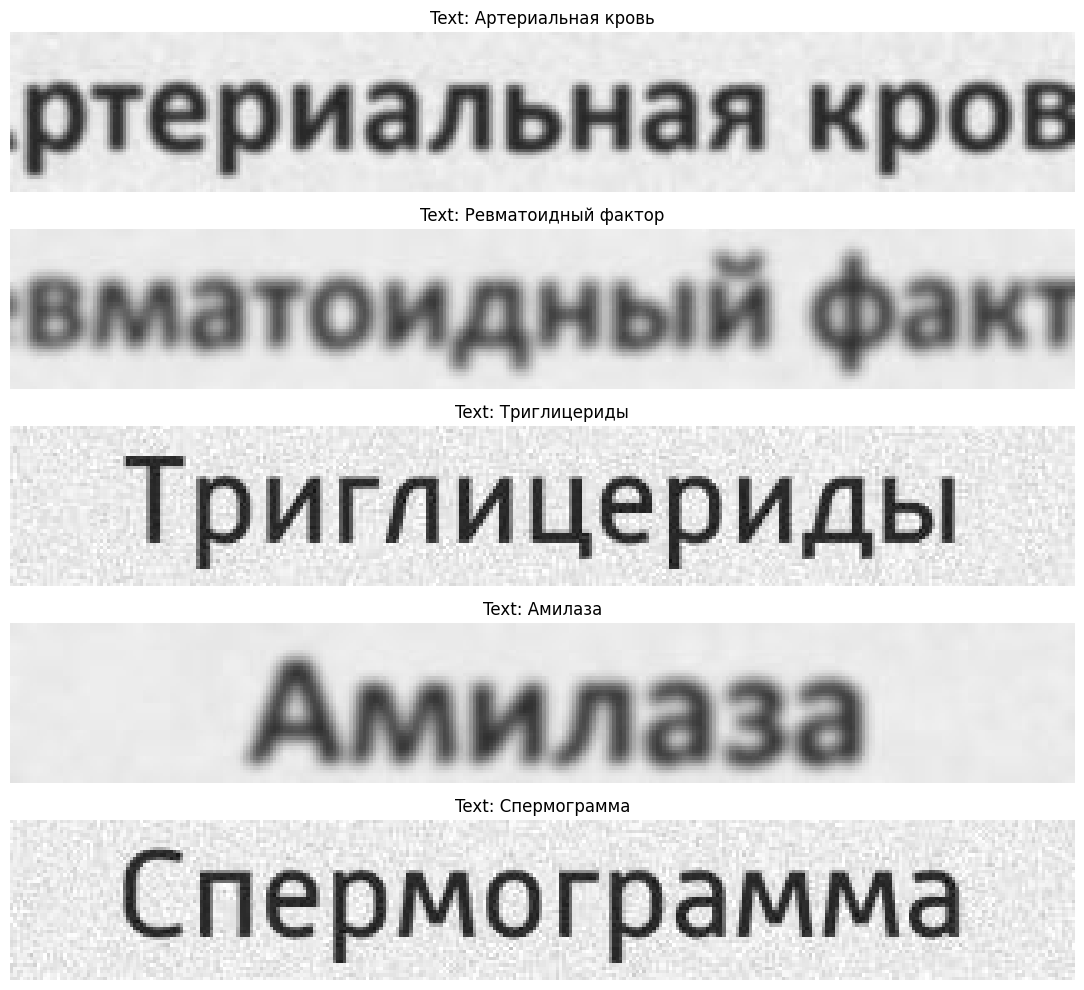

In [3]:
# Cell 4: Create Test Dataset from Training Data
import os
import shutil

# Paths configuration
train_dir = "/home/ubuntu/OCR/data/rec/train1"
test_dir = "/home/ubuntu/OCR/data/rec/test1"
train_anno_path = "/home/ubuntu/OCR/data/rec/rec_gt_train1.txt"
test_anno_path = "/home/ubuntu/OCR/data/rec/rec_gt_test1.txt"

# Create test directory if it doesn't exist
os.makedirs(test_dir, exist_ok=True)

# Read first 10 lines from training annotations
with open(train_anno_path, "r", encoding="utf-8") as f:
    annotations = [line.strip() for line in f.readlines()[:10]]

# Prepare test annotations
test_annotations = []

# Copy files and create new annotations
for annotation in annotations:
    parts = annotation.split("\t")
    if len(parts) == 2:
        train_path, text = parts

        # Get filename
        file_name = os.path.basename(train_path)

        # Create path to test file
        test_path = os.path.join(test_dir, file_name)

        # Copy file
        if os.path.exists(train_path):
            shutil.copy2(train_path, test_path)
            print(f"Copied file: {file_name}")

            # Create new annotation with path to test directory
            test_anno_line = f"/home/ubuntu/OCR/data/rec/test1/{file_name}\t{text}"
            test_annotations.append(test_anno_line)
        else:
            print(f"File not found: {train_path}")

# Write new annotations to test file
with open(test_anno_path, "w", encoding="utf-8") as f:
    for anno in test_annotations:
        f.write(f"{anno}\n")

print(f"\nCopied {len(test_annotations)} files from {train_dir} to {test_dir}")
print(f"Created annotation file: {test_anno_path}")

# Cell 5: Display Sample Images (Optional)
import matplotlib.pyplot as plt
import random
from PIL import Image

# Get a few sample images
sample_images = []
with open(train_anno_path, "r", encoding="utf-8") as f:
    all_annotations = f.readlines()
    # Get 5 random samples
    samples = random.sample(all_annotations, min(5, len(all_annotations)))

    for sample in samples:
        parts = sample.strip().split("\t")
        if len(parts) == 2:
            image_path, text = parts
            if os.path.exists(image_path):
                sample_images.append((image_path, text))

# Display samples
if sample_images:
    plt.figure(figsize=(15, 10))
    for i, (image_path, text) in enumerate(sample_images):
        img = Image.open(image_path)
        plt.subplot(len(sample_images), 1, i + 1)
        plt.imshow(img)
        plt.title(f"Text: {text}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No sample images found")